Read embedding data

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_parquet('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/data/embeddings.parquet')
data = data.drop('original_index', axis=1)
data.head(4)

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_3062,dim_3063,dim_3064,dim_3065,dim_3066,dim_3067,dim_3068,dim_3069,dim_3070,dim_3071
0,-0.043554,-0.015081,-0.001326,0.008543,0.035059,-0.002354,-0.037854,0.015606,-0.053765,-0.006925,...,-0.002285,-0.008239,-0.004545,-0.002018,0.010529,0.020089,0.003701,-0.000709,-0.007499,0.019245
1,-0.027199,-0.008029,0.013194,0.000585,0.047060,-0.018106,-0.014450,0.020579,-0.030363,-0.035095,...,-0.010436,0.015926,-0.047405,0.003473,0.014636,0.002212,0.006092,0.001830,0.015235,-0.027358
2,-0.012802,0.025817,0.001080,0.005417,0.072452,0.018418,-0.012259,0.015275,-0.002460,0.026825,...,-0.008108,0.019598,0.005639,0.017702,0.007717,0.002843,-0.023019,0.005735,-0.008122,0.025154
3,0.024636,0.022683,0.006875,0.040642,0.039903,-0.006383,-0.002176,0.008465,-0.037580,0.001014,...,-0.015452,-0.001804,-0.005935,-0.000479,-0.018658,-0.001586,-0.000676,-0.017326,-0.005921,0.008953


Read question data

In [ ]:
preprocess = pd.read_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/data/preproces.csv')
preprocess.head(3)

,Question,ID,normelized,Preposition,preprocessed
0,من الگوی رگالی رو تهیه کردم و می‌خوام باهاش لب...,1,من الگو رگال رو تهیه کرد#کن می‌خوام با لباس جل...,الگو رگال تهیه کرد#کن می‌خوام لباس جلو بسته ما...,الگو رگال تهیه می‌خوام لباس جلو بسته مانتو جلو...
1,اگر همون خط جلو رو در نظر بگیرم، یقه خیلی از ب...,2,اگر همون خط جلو رو در نظر گرفت#گیر یقه خیلی از...,همون خط جلو نظر گرفت#گیر یقه خیلی بغل باز میشه...,همون خط جلو نظر یقه خیلی بغل باز نظر شما انداز...
2,چرا من نمی تونم وارد سایت دوخت برتر بشم؟,3,چرا من نمی‌تونم وارد سایت دوخت برتر بشم,چرا نمی‌تونم وارد سایت دوخت برتر بشم,نمی‌تونم وارد سایت دوخت برتر


Read cluster labels

In [ ]:
clusters = pd.read_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/question/Findcluster/kmeans63_result.csv')
clusters.head(3)
# clusters = clusters.drop('Unnamed: 0', axis=1)
# clusters.to_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/question/kmeans63_result.csv', index=False)
# clusters.head(3)

,clusters
0,13
1,6
2,14


Find the closest points

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

def get_closest_points_with_questions(embedding_data, clusters_df, preprocess_df, n_points=3):
    """
    Find the closest points to each cluster centroid using cosine distance and return their related questions.

    Parameters:
    -----------
    embedding_data : numpy.ndarray or pandas.DataFrame
        Embedding vectors.
    clusters_df : pandas.DataFrame or pandas.Series
        Cluster labels for each data point.
    preprocess_df : pandas.DataFrame
        DataFrame containing the original questions in the 'Question' column.
    n_points : int
        Number of closest points to return per cluster.
    """
    # Convert to numpy array if necessary
    if isinstance(embedding_data, pd.DataFrame):
        embedding_data = embedding_data.values

    if isinstance(clusters_df, pd.DataFrame):
        cluster_labels = clusters_df.iloc[:, 0].values
    else:
        cluster_labels = clusters_df.values

    # Number of clusters
    n_clusters = len(np.unique(cluster_labels))

    # Dictionary to store the results
    closest_points_dict = {}

    for cluster_id in range(n_clusters):
        # Get points that belong to this cluster
        cluster_mask = cluster_labels == cluster_id
        cluster_points = embedding_data[cluster_mask]

        if len(cluster_points) == 0:
            continue

        # Compute cluster centroid
        centroid = np.mean(cluster_points, axis=0)

        # Normalize the centroid (important for cosine distance)
        centroid_norm = centroid / np.linalg.norm(centroid)

        # Compute cosine distances to all points in the cluster
        distances = cosine_distances([centroid_norm], cluster_points)[0]

        # Get original indices from the full dataset
        original_indices = np.where(cluster_mask)[0]

        # Sort and select top n_points
        sorted_indices = np.argsort(distances)[:n_points]
        closest_indices = original_indices[sorted_indices]
        closest_distances = distances[sorted_indices]

        # Get corresponding questions
        closest_questions = preprocess_df.iloc[closest_indices]['Question'].tolist()

        # Store results
        closest_points_dict[cluster_id] = {
            'indices': closest_indices.tolist(),
            'distances': closest_distances.tolist(),
            'questions': closest_questions
        }

    return closest_points_dict

# Call the function
closest_points = get_closest_points_with_questions(data, clusters, preprocess)

# Display results
for cluster_id, cluster_data in closest_points.items():
    print(f"\n=== Cluster {cluster_id} ===")
    print(f"Number of points in cluster: {np.sum(clusters == cluster_id)}")

    print("\nTop 30 questions closest to centroid:")
    for i, (idx, dist, question) in enumerate(zip(
        cluster_data['indices'],
        cluster_data['distances'],
        cluster_data['questions']
    )):
        print(f"{i+1}. [Index: {idx}, Distance: {dist:.4f}] {question}")

    print("-" * 80)

# Save results to CSV
results = []
for cluster_id, cluster_data in closest_points.items():
    for idx, (point_idx, distance, question) in enumerate(zip(
        cluster_data['indices'],
        cluster_data['distances'],
        cluster_data['questions']
    )):
        results.append({
            'cluster_id': cluster_id,
            'rank': idx + 1,
            'point_index': point_idx,
            'distance_to_centroid': distance,
            'question': question
        })

results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/question/withQuestion/clusterWithQuestion_kmean63.csv', index=False)
print("\nResults saved to 'clusterWithQuestion_kmean63.csv'")



=== Cluster 0 ===
Number of points in cluster: clusters    931
dtype: int64

Top 30 questions closest to centroid:
1. [Index: 50555, Distance: 0.1857] من الان تو الگو ام مشکل دارم، چه برسه به بریدن و دوخت.
2. [Index: 15205, Distance: 0.1933] دوره الگو و قسمت 2 برای من باز نمی‌شود، این مشکل چیست؟
3. [Index: 67607, Distance: 0.1971] آیا فقط الگویی که من گرفتم این مشکل را داشته است؟
--------------------------------------------------------------------------------

=== Cluster 1 ===
Number of points in cluster: clusters    910
dtype: int64

Top 30 questions closest to centroid:
1. [Index: 15508, Distance: 0.1287] این دامن هم چه مقدار پارچه لازم هست؟
2. [Index: 27703, Distance: 0.1296] واسه این مدل چقدر متراژ پارچه لازمه؟
3. [Index: 40712, Distance: 0.1312] برای دنباله چند متر پارچه لازمه؟
--------------------------------------------------------------------------------

=== Cluster 2 ===
Number of points in cluster: clusters    856
dtype: int64

Top 30 questions closest to centroid:
1. [Ind

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)



Results saved to 'topSphericalKmean.csv'


distribution of data points

=== Cluster Distribution ===

Ordered by cluster ID:
    cluster_id  count  percentage
0            0    931        1.21
1            1    910        1.18
2            2    856        1.11
3            3   1246        1.61
4            4    904        1.17
..         ...    ...         ...
58          58   2040        2.64
59          59    660        0.85
60          60   2782        3.60
61          61   1532        1.98
62          62    700        0.91

[63 rows x 3 columns]

Ordered by cluster size (largest first):
    cluster_id  count  percentage
0           43   3284        4.25
1           60   2782        3.60
2           16   2233        2.89
3            5   2159        2.80
4           58   2040        2.64
..         ...    ...         ...
58          31    713        0.92
59          20    709        0.92
60          62    700        0.91
61          59    660        0.85
62          45    534        0.69

[63 rows x 3 columns]

Results saved to 'cluster_distribution.csv

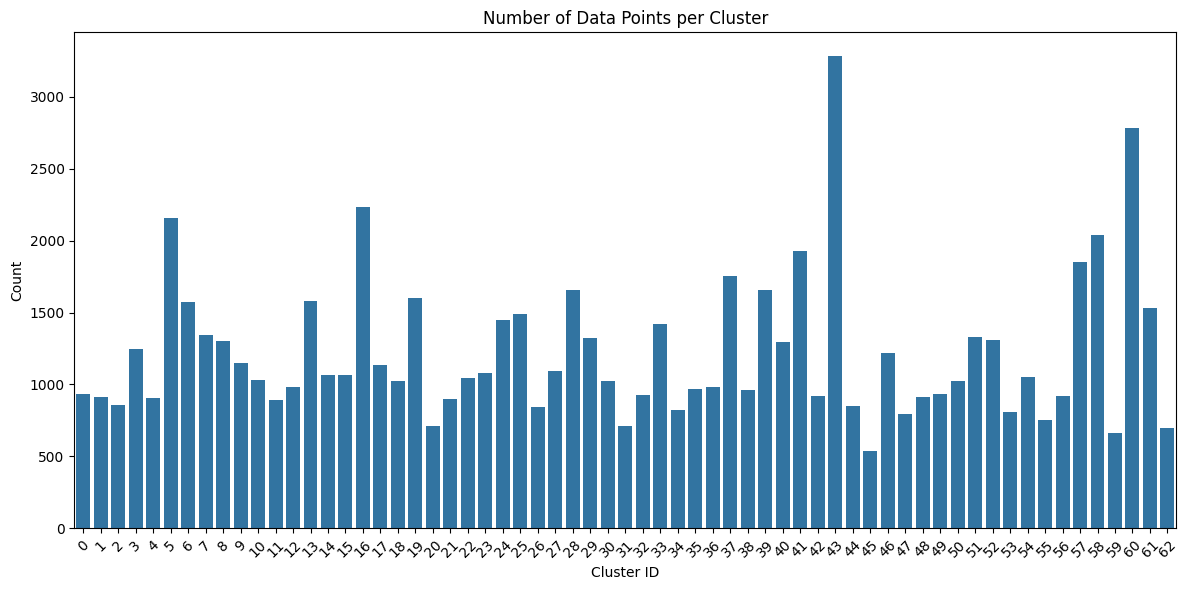

<Figure size 1000x1000 with 0 Axes>

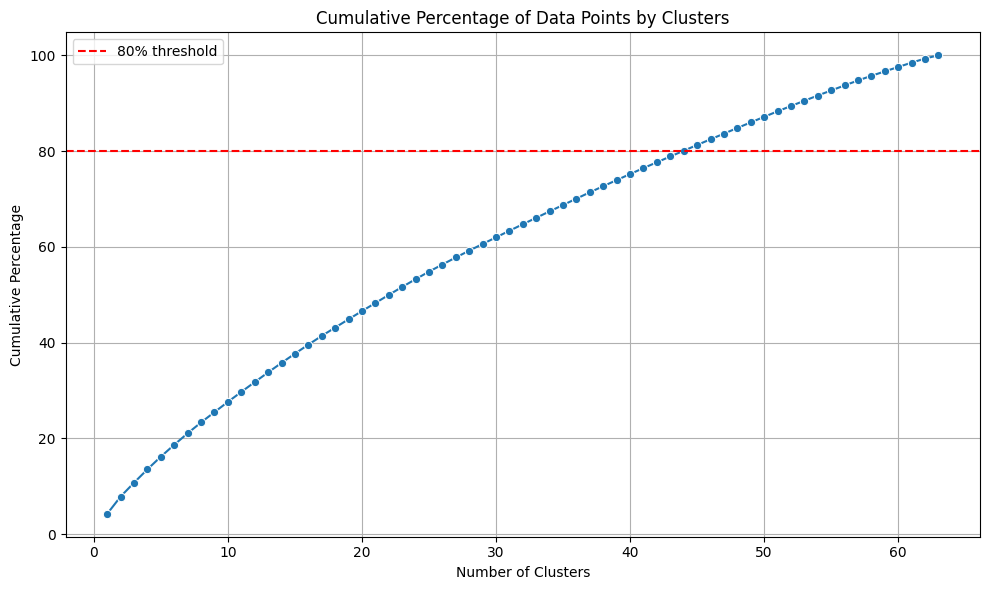


=== Descriptive Statistics ===
Total number of clusters: 63
Total number of data points: 77224
Largest cluster: Cluster 43.0 with 3284.0 points (4.25%)
Smallest cluster: Cluster 45.0 with 534.0 points (0.69%)

44 clusters cover 80% of the data

Gini coefficient (measure of inequality): 0.2055
(0 = perfect equality, 1 = perfect inequality)

Cumulative distribution saved to 'cluster_cumulative_distribution.csv'


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cluster_distribution(clusters):
    """
    Analyze the distribution of data points across clusters

    Parameters:
    -----------
    clusters : numpy.ndarray or pandas.Series or pandas.DataFrame
        Cluster labels for each data point

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing cluster distribution info
    """
    # Convert to Series if it's a numpy array
    if isinstance(clusters, np.ndarray):
        clusters = pd.Series(clusters)
    elif isinstance(clusters, pd.DataFrame):
        clusters = clusters.iloc[:, 0]

    # Count number of points per cluster
    cluster_counts = clusters.value_counts().sort_index()

    # Calculate percentage of total points per cluster
    total_points = len(clusters)
    cluster_percentages = (cluster_counts / total_points * 100).round(2)

    # Create results DataFrame
    results = pd.DataFrame({
        'cluster_id': cluster_counts.index,
        'count': cluster_counts.values,
        'percentage': cluster_percentages.values
    })

    # Sort by cluster size (descending)
    results_by_size = results.sort_values('count', ascending=False).reset_index(drop=True)

    return results, results_by_size

# Run the analysis
cluster_stats, cluster_stats_by_size = analyze_cluster_distribution(clusters)

# Display results
print("=== Cluster Distribution ===")
print("\nOrdered by cluster ID:")
print(cluster_stats)

print("\nOrdered by cluster size (largest first):")
print(cluster_stats_by_size)

# Save results to CSV files
cluster_stats.to_csv('cluster_distribution.csv', index=False)
cluster_stats_by_size.to_csv('cluster_distribution_by_size.csv', index=False)
print("\nResults saved to 'cluster_distribution.csv' and 'cluster_distribution_by_size.csv'")

# Visualize cluster distribution with bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster_id', y='count', data=cluster_stats)
plt.title('Number of Data Points per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('cluster_distribution.png', dpi=300)
plt.show()

# Visualize pie chart for top 10 clusters
plt.figure(figsize=(10, 10))
top_clusters = cluster_stats_by_size.head(10)
if len(cluster_stats_by_size) > 10:
    # Combine smaller clusters into "Others"
    other_sum = cluster_stats_by_size.iloc[10:]['count'].sum()
    other_percent = cluster_stats_by_size.iloc[10:]['percentage'].sum()
    other = pd.DataFrame({
        'cluster_id': ['Others'],
        'count': [other_sum],
        'percentage': [other_percent]
    })
    pie_data = pd.concat([top_clusters, other])
else:
    pie_data = top_clusters

# Optional: pie chart code (commented out)
# labels = [f'Cluster {row.cluster_id} ({row.count}, {row.percentage}%)'
#           if row.cluster_id != 'Others'
#           else f'Others ({row.count}, {row.percentage}%)'
#           for _, row in pie_data.iterrows()]

# plt.pie(pie_data['count'], labels=labels, autopct='%1.1f%%',
#         startangle=90, shadow=True, explode=[0.05]*len(pie_data))
# plt.title('Distribution of Data Points Across Clusters')
# plt.axis('equal')  # For a perfect circle
# plt.tight_layout()
# plt.show()

# Visualize cumulative distribution
plt.figure(figsize=(10, 6))
cumulative = cluster_stats_by_size.copy()
cumulative['cumulative_percentage'] = cumulative['percentage'].cumsum()

sns.lineplot(x=range(1, len(cumulative) + 1), y=cumulative['cumulative_percentage'], marker='o')
plt.axhline(y=80, color='r', linestyle='--', label='80% threshold')
plt.title('Cumulative Percentage of Data Points by Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cumulative Percentage')
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig('cluster_cumulative_distribution.png', dpi=300)
plt.show()

# Descriptive statistics
print("\n=== Descriptive Statistics ===")
print(f"Total number of clusters: {len(cluster_stats)}")
print(f"Total number of data points: {cluster_stats['count'].sum()}")
print(f"Largest cluster: Cluster {cluster_stats_by_size.iloc[0]['cluster_id']} with {cluster_stats_by_size.iloc[0]['count']} points ({cluster_stats_by_size.iloc[0]['percentage']}%)")
print(f"Smallest cluster: Cluster {cluster_stats_by_size.iloc[-1]['cluster_id']} with {cluster_stats_by_size.iloc[-1]['count']} points ({cluster_stats_by_size.iloc[-1]['percentage']}%)")

# Calculate number of clusters that cover 80% of the data
clusters_for_80_percent = cumulative[cumulative['cumulative_percentage'] >= 80].index[0] + 1
print(f"\n{clusters_for_80_percent} clusters cover 80% of the data")

# Calculate Gini coefficient
def gini_coefficient(counts):
    counts = np.sort(counts)
    n = len(counts)
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * counts)) / (n * np.sum(counts))

gini = gini_coefficient(cluster_stats['count'].values)
print(f"\nGini coefficient (measure of inequality): {gini:.4f}")
print("(0 = perfect equality, 1 = perfect inequality)")

# Save cumulative distribution
cumulative.to_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/question/withQuestion/distribution_kmean63.csv', index=False)
print("\nCumulative distribution saved to 'distribution_kmean63.csv'")


Euclidean distance

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def get_closest_points_with_questions(embedding_data, clusters_df, preprocess_df, n_points=3):
    """
    Find the closest points to each cluster centroid using Euclidean distance and return their related questions.

    Parameters:
    -----------
    embedding_data : numpy.ndarray or pandas.DataFrame
        Embedding vectors.
    clusters_df : pandas.DataFrame or pandas.Series
        Cluster labels for each data point.
    preprocess_df : pandas.DataFrame
        DataFrame containing original questions in the 'Question' column.
    n_points : int
        Number of closest points to return per cluster.
    """
    if isinstance(embedding_data, pd.DataFrame):
        embedding_data = embedding_data.values

    if isinstance(clusters_df, pd.DataFrame):
        cluster_labels = clusters_df.iloc[:, 0].values
    else:
        cluster_labels = clusters_df.values

    n_clusters = len(np.unique(cluster_labels))
    closest_points_dict = {}

    for cluster_id in range(n_clusters):
        cluster_mask = cluster_labels == cluster_id
        cluster_points = embedding_data[cluster_mask]

        if len(cluster_points) == 0:
            continue

        centroid = np.mean(cluster_points, axis=0)
        distances = euclidean_distances([centroid], cluster_points)[0]
        original_indices = np.where(cluster_mask)[0]
        sorted_indices = np.argsort(distances)[:n_points]

        closest_indices = original_indices[sorted_indices]
        closest_distances = distances[sorted_indices]
        closest_questions = preprocess_df.iloc[closest_indices]['Question'].tolist()

        closest_points_dict[cluster_id] = {
            'indices': closest_indices.tolist(),
            'distances': closest_distances.tolist(),
            'questions': closest_questions
        }

    return closest_points_dict

# Apply the function
closest_points = get_closest_points_with_questions(data, clusters, preprocess, n_points=4)

# Display results
for cluster_id, cluster_data in closest_points.items():
    print(f"\n=== Cluster {cluster_id} ===")
    print(f"Number of points in cluster: {np.sum(clusters == cluster_id)}")

    print("\nTop questions closest to centroid:")
    for i, (idx, dist, question) in enumerate(zip(
        cluster_data['indices'],
        cluster_data['distances'],
        cluster_data['questions']
    )):
        print(f"{i+1}. [Index: {idx}, Distance: {dist:.4f}] {question}")

    print("-" * 80)

# Save results to CSV
results = []
for cluster_id, cluster_data in closest_points.items():
    for idx, (point_idx, distance, question) in enumerate(zip(
        cluster_data['indices'],
        cluster_data['distances'],
        cluster_data['questions']
    )):
        results.append({
            'cluster_id': cluster_id,
            'rank': idx + 1,
            'point_index': point_idx,
            'distance_to_centroid': distance,
            'question': question
        })

results_df = pd.DataFrame(results)
results_df.to_csv('/content/drive/MyDrive/Doukt/Goftino/NLP/colab/question/withQuestion/topKmean.csv', index=False)
print("\nResults saved to 'topKmean.csv'")

# Optional: clustering summary
# print("\n=== Clustering Statistics ===")
# cluster_sizes = pd.Series(clusters).value_counts().sort_index()
# print("\nPoints per cluster:")
# for cluster_id, size in cluster_sizes.items():
#     print(f"Cluster {cluster_id}: {size} points")

# print(f"\nTotal number of clusters: {len(cluster_sizes)}")
# print(f"Total number of points: {len(clusters)}")


KeyError: 'Question'